# SDL4Kids.com: Your first self-driving laboratory （MacOS version)

This notebook helps you run your first SDL, using the BBC Micro:bit, see [sdl4kids.com](http://sdl4kids.com).

Go to [sdl4kids.com](http://sdl4kids.com) for the Windows version.

If you have any questions, check out the [FAQ](https://sites.google.com/matterhorn.studio/sdl4kids/faq)!

## Introduction

In this notebook, you will run your first closed-loop SDL.

Every SDL has three core components

1. Synthesis: We will use your computer screen to generate rectangles with different RGB colors (Synthesis).
2. Characterisation: We will use the Microbit to measure (Characterisation) the RGB color on the screen. 
3. Planning: We will use different strategies to find the correct RGB color combination.

## (1) Synthesis: Using your screen as an RGB color generator

**Goal**: You will learn how to display different RGB colors on your screen.

RGB stands for Red Green Blue. By mixing these three colors, we can create all kinds of colors on your screen. Most simply, if you put Red to its maximum of 255, and keep the other two at zero, then you will get a complete red screen.

In [189]:
import cv2
import numpy as np

In [190]:
blue = 0
green = 0
red = 255
current_color = (blue, green, red)

The following code will open up a red rectangle:

In [191]:
# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()
image[:, :] = current_color
# Display the image
cv2.imshow("Live Image", image)

cv2.waitKey(3000)  # Adjust the wait time (in milliseconds) as needed
# Close the CV2 window
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

**Task**: Now try it yourself: Change the RGB values above, and see what different rectangles you can create!

## (2) Characterisation: Using the Microbit with the Envirobit to measure RGB colors

**Goal**: You will be able to measure RGB colors with the Microbit
We will use the 'pyserial' library. Let's make sure it is installed

**Tasks**: 
1. Program the Microbit to measure RGB color on request.
2. Connect the Microbit to the computer, and make sure we request new measurements from it.

### (2.1) Programming the Microbit to send new RGB color measurements

Slot your Microbit into the Envirobit extension board. Then, plug it into a USB socket on your computer and follow these steps:

1. Open MakeCode [here](https://makecode.microbit.org/#editor).
2. In the middle column, somewhere between "Math" and "Variables" click on "Extensions".
3. Search for "envirobit", then click on it to load the envirobit library into your Microbit program.
4. Drag and drop the below program into your Microbit.

![Microbit Program](img/microbit_program.png "Microbit Program")

5. Alternatively, you can copy and paste the following code into the "JavaScript" section (switch to JavaScript via its button in the middle of the top bar):
```
serial.onDataReceived(serial.delimiters(Delimiters.Comma), function () {
    serial.writeLine(envirobit.getGreen() + "-" + envirobit.getRed() + "-" + envirobit.getBlue())
    music.playTone(262, music.beat(BeatFraction.Sixteenth))
})
music.setVolume(127)
```


### (2.2) Connecting to the Microbit and requesting new measurements

**Warning**: Make 100% sure that you disconnected your Microbit from Google Chrome before continuing. Otherwise, Google Chrome will interfere with the serial connection and you cannot request values

Let's import the 'pyserial' package, which we use to connect to the Microbit (it is just called 'serial'):

In [192]:
!pip install pyserial

In [193]:
import serial

We will list all USB devices currently connected to our computer:

In [194]:
!ls /dev/cu.*

/dev/cu.Bluetooth-Incoming-Port /dev/cu.ZeitlersBoseQC35II
/dev/cu.RoastBeats              /dev/cu.usbmodem2102


Choose the one with 'cu.usbmodem' in its name and copy its name below:

In [195]:
ser = serial.Serial()
ser=serial.Serial("/dev/cu.usbmodem2102",115200, timeout=0.1)

In [212]:
ser.flushInput()
ser.write(b",")
serial_data = str(ser.readline().decode('utf8')).rstrip()
rgb = tuple([int(value) for value in serial_data.split("-")])
rgb

(95, 76, 78)

In [220]:
def characterise():
    ser.flushInput()
    ser.write(b",")
    serial_data = str(ser.readline().decode('utf8')).rstrip()
    rgb = tuple([int(value) for value in serial_data.split("-")])
    print(f"New RGB Measurement: {rgb}")
    return rgb

In [221]:
characterise()

New RGB Measurement: (98, 70, 80)


(98, 70, 80)

## (3) Planning: Using different search strategies: Random, Grid, Bayesian Optimisation

### (3.1) Generate a random color with CV2

In [225]:
import random
import numpy as np
import cv2

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return blue, green, red  # OpenCV uses BGR color format

# Function to calculate the loss between two colors
def calculate_loss(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (0, 0, 255)  # Red color (BGR format)

# Create an empty list to store the loss values
loss_values = []

# Main loop
max_iterations = 200  # Set the desired number of iterations

candidate_color = (0,0,0) # Initial candidate

for iteration in range(max_iterations):
    

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = candidate_color
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    # Measure the color
    rgb_measurement = characterise()
    rgb_measurement = tuple(reversed(rgb_measurement))
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    loss = calculate_loss(goal_color, rgb_measurement)

    # Add the loss value to the list
    loss_values.append(loss)    

    # Add text information to the image
    text = f"Iteration: {num_iterations + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the loss
    loss_text = f"Loss: {loss:.2f}"
    cv2.putText(image, loss_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of loss values
    if len(loss_values) > 1:
        for i in range(1, len(loss_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(loss_values[i - 1] * (height - 60) / max(loss_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(loss_values[i] * (height - 60) / max(loss_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(100)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = generate_random_color()
    
    num_iterations += 1

# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

New RGB Measurement: (90, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (77, 85, 90)
New RGB Measurement: (77, 85, 90)
New RGB Measurement: (77, 85, 90)
New RGB Measurement: (77, 85, 90)
New RGB Measurement: (88, 102, 62)
New RGB Measurement: (88, 102, 62)
New RGB Measurement: (88, 102, 62)
New RGB Measurement: (88, 102, 62)
New RGB Measurement: (88, 102, 62)
New RGB Measurement: (101, 77, 73)
New RGB Measurement: (101, 77, 73)
New RGB Measurement: (101, 77, 73)
New RGB Measurement: (101, 77, 73)
New RGB Measurement: (82, 77, 91)
New RGB Measurement: (82, 77, 91)
New RGB Measurement: (82, 77, 91)
New RGB Measurement: (82, 77, 91)
New RGB Measurement: (118, 58, 72)
New RGB Measurement: (118, 58, 72)
New RGB Measurement: (118, 58, 72)
New RGB Measurement: (118, 58, 72)
New RGB Measurement: (118, 58, 72)
New RGB Measurement: (99, 53, 95)
New RGB Measurement: (99, 53, 95)


-1

In [226]:
import matplotlib.pyplot as plt
plt.plot(loss_values)

ModuleNotFoundError: No module named 'matplotlib'

### (3.2) Use a search over a grid to find the best RGB combination

TBD Explanation

In [239]:
grid_steps = 6
red = np.linspace(0, 255, grid_steps)
green = np.linspace(0, 255, grid_steps)
blue = np.linspace(0, 255, grid_steps)

grid_combinations = []
for r in red:
    for g in green:
        for b in blue:
            combination = (r,g,b)
            grid_combinations.append(combination)
grid_combinations

[(0.0, 0.0, 0.0),
 (0.0, 0.0, 51.0),
 (0.0, 0.0, 102.0),
 (0.0, 0.0, 153.0),
 (0.0, 0.0, 204.0),
 (0.0, 0.0, 255.0),
 (0.0, 51.0, 0.0),
 (0.0, 51.0, 51.0),
 (0.0, 51.0, 102.0),
 (0.0, 51.0, 153.0),
 (0.0, 51.0, 204.0),
 (0.0, 51.0, 255.0),
 (0.0, 102.0, 0.0),
 (0.0, 102.0, 51.0),
 (0.0, 102.0, 102.0),
 (0.0, 102.0, 153.0),
 (0.0, 102.0, 204.0),
 (0.0, 102.0, 255.0),
 (0.0, 153.0, 0.0),
 (0.0, 153.0, 51.0),
 (0.0, 153.0, 102.0),
 (0.0, 153.0, 153.0),
 (0.0, 153.0, 204.0),
 (0.0, 153.0, 255.0),
 (0.0, 204.0, 0.0),
 (0.0, 204.0, 51.0),
 (0.0, 204.0, 102.0),
 (0.0, 204.0, 153.0),
 (0.0, 204.0, 204.0),
 (0.0, 204.0, 255.0),
 (0.0, 255.0, 0.0),
 (0.0, 255.0, 51.0),
 (0.0, 255.0, 102.0),
 (0.0, 255.0, 153.0),
 (0.0, 255.0, 204.0),
 (0.0, 255.0, 255.0),
 (51.0, 0.0, 0.0),
 (51.0, 0.0, 51.0),
 (51.0, 0.0, 102.0),
 (51.0, 0.0, 153.0),
 (51.0, 0.0, 204.0),
 (51.0, 0.0, 255.0),
 (51.0, 51.0, 0.0),
 (51.0, 51.0, 51.0),
 (51.0, 51.0, 102.0),
 (51.0, 51.0, 153.0),
 (51.0, 51.0, 204.0),
 (51.0, 51.0, 

In [240]:
import random
import numpy as np
import cv2

# Function to generate random color
def generate_random_color():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return blue, green, red  # OpenCV uses BGR color format

# Function to calculate the loss between two colors
def calculate_loss(color1, color2):
    return np.sqrt((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2)

# Create a blank image
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)

# Create a named window for display
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
cv2.startWindowThread()

# Define font properties for displaying text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)  # White color

# Define the goal color
goal_color = (0, 0, 255)  # Red color (BGR format)

# Create an empty list to store the loss values
loss_values = []

# Main loop
max_iterations = len(grid_combinations)  # Set the desired number of iterations

candidate_color = grid_combinations[0]

for grid_combination in grid_combinations:
    

    # STEP 1: Synthesis
    # Update the live image with the current color
    image[:, :] = candidate_color
    
    # Display the image
    cv2.imshow("Live Image", image)
    
    # STEP 2: Characterisation
    # Measure the color
    rgb_measurement = characterise()
    rgb_measurement = tuple(reversed(rgb_measurement))
    
    # STEP 3: Planning
    
    # Calculate the loss between the goal color and the current color
    loss = calculate_loss(goal_color, rgb_measurement)

    # Add the loss value to the list
    loss_values.append(loss)    

    # Add text information to the image
    text = f"Iteration: {num_iterations + 1}"
    cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

    # Plot a subplot for the goal color
    # subplot_x = num_iterations * (width // (max_iterations + 1))
    subplot_x = width // (max_iterations + 1)
    subplot_width = width // (max_iterations + 1)
    cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)

    # Add text for the loss
    loss_text = f"Loss: {loss:.2f}"
    cv2.putText(image, loss_text, (10, height - 10), font, font_scale, font_color, 2)

    # Draw the graph of loss values
    if len(loss_values) > 1:
        for i in range(1, len(loss_values)):
            x1 = (i - 1) * (width // max_iterations)
            y1 = height - int(loss_values[i - 1] * (height - 60) / max(loss_values))
            x2 = i * (width // max_iterations)
            y2 = height - int(loss_values[i] * (height - 60) / max(loss_values))
            cv2.line(image, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Increment the iteration counter
    cv2.imshow("Live Image", image)
    cv2.waitKey(100)  # Adjust the wait time (in milliseconds) as needed
    
    # Generate a new candidate color, for now we will pick one randomly
    candidate_color = grid_combination
    
    num_iterations += 1

# Close the window after the desired number of iterations
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)

New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (91, 86, 75)
New RGB Measurement: (67, 126, 57)
New RGB Measurement: (67, 126, 57)
New RGB Measurement: (67, 126, 57)
New RGB Measurement: (67, 126, 57)
New RGB Measurement: (67, 126, 57)
New RGB Measurement: (57, 156, 45)
New RGB Measurement: (57, 156, 45)
New RGB Measurement: (57, 156, 45)
New RGB Measurement: (57, 156, 45)
New RGB Measurement: (62, 155, 43)
New RGB Measurement: (62, 155, 43)
New RGB Measurement: (62, 155, 43)
New RGB Measurement: (62, 155, 43)
New RGB Measurement: (81, 130, 45)
New RGB Measurement: (81, 130, 45)
New RGB Measurement: (81, 130, 45)
New RGB Measurement: (81, 130, 45)
New RGB Measurement: (81, 130, 45)
New RGB Measurement: (109, 95, 47)
New RGB Measurement: (109, 95, 47)
New RGB Measurement: (109, 95, 47)
New RGB Measurement: (109, 95, 47)
New RGB Measurement: (106,

-1

### (3.3) Use Bayesian Optimisation to search for the optimal RGB combination

(Characterisation) Measure RGB sample:
{'R': 117, 'G': 71, 'B': 61, 'outcome': 237.41524803600967, 'time': 1689539005.017233}
(Characterisation) Measure RGB sample:
{'R': 122, 'G': 69, 'B': 59, 'outcome': 240.95850265139018, 'time': 1689539005.975181}
(Characterisation) Measure RGB sample:
{'R': 68, 'G': 109, 'B': 65, 'outcome': 229.35779908256882, 'time': 1689539006.944224}
(Characterisation) Measure RGB sample:
{'R': 135, 'G': 64, 'B': 56, 'outcome': 248.84131489766727, 'time': 1689539007.918304}
(Characterisation) Measure RGB sample:
{'R': 187, 'G': 34, 'B': 38, 'outcome': 288.46836914989484, 'time': 1689539008.887062}
(Characterisation) Measure RGB sample:
{'R': 186, 'G': 37, 'B': 37, 'outcome': 288.9446313742479, 'time': 1689539010.155988}
(Characterisation) Measure RGB sample:
{'R': 179, 'G': 43, 'B': 38, 'outcome': 284.568093784247, 'time': 1689539011.450079}
(Characterisation) Measure RGB sample:
{'R': 186, 'G': 37, 'B': 32, 'outcome': 292.7353753819309, 'time': 1689539012.7279

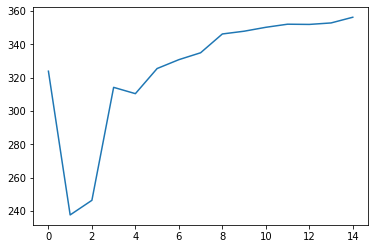

In [7]:
import serial
import time
import numpy as np
import cv2
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

ser = serial.Serial("/dev/cu.usbmodem144102", 115200)

# Define the optimization goal
goal_color = (0, 0, 255)  # Red color (BGR format)

# Initialize CV2 window for live image display
width, height = 800, 400
image = np.zeros((height, width, 3), dtype=np.uint8)
cv2.namedWindow("Live Image", cv2.WINDOW_NORMAL)
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.8
font_color = (255, 255, 255)

max_iterations = 15  # Set the desired number of iterations

serial_line_tested = False
def test_serial_line():
    ser.write(b",")
    serial_data = str(ser.readline().decode('utf8'))
    serial_data = str(ser.readline().decode('utf8'))
    serial_data = str(ser.readline().decode('utf8'))
    # do nothing with it
    global serial_line_tested
    serial_line_tested = True

def calculate_loss(color1, color2):
    return np.sqrt(
        (color1[0] - color2["R"]) ** 2
        + (color1[1] - color2["G"]) ** 2
        + (color1[2] - color2["B"]) ** 2
    )

def measure_outcome():
    if not serial_line_tested:
        test_serial_line()
    time.sleep(0.4)
    print('(Characterisation) Measure RGB sample:')
    ser.write(b",")
    serial_data = str(ser.readline().decode('utf-8'))
    new_sample = {}
    while True:
        color, val = serial_data.split(":")
        new_sample[str(color)] = int(val)
        if color == "B":
            break
        else:
            serial_data = str(ser.readline().decode('utf-8'))

    # Make sure the keys "R", "G", and "B" exist in the new_sample dictionary
    for color_key in ["R", "G", "B"]:
        if color_key not in new_sample:
            new_sample[color_key] = 0

    new_sample["outcome"] = calculate_loss(goal_color, new_sample)
    new_sample["time"] = time.time()

    print(new_sample)
    return new_sample

def objective_function(R, G, B):
    # Simulate the outcome based on the RGB values
    outcome = calculate_loss(goal_color, {'R': R, 'G': G, 'B': B})
    return outcome

# Define the utility function (Expected Improvement)
utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

loss_values = []

if __name__ == "__main__":
    # Define the search space bounds
    pbounds = {'R': (0, 255), 'G': (0, 255), 'B': (0, 255)}

    # Define the Bayesian optimization function
    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=pbounds,
        random_state=1,
        verbose=2
    )

    for iteration in range(max_iterations):
        # Measure the outcome from the micro:bit
        new_sample = measure_outcome()

        # Update the optimizer with the new sample
        optimizer.register(params={'R': new_sample['R'], 'G': new_sample['G'], 'B': new_sample['B']}, target=new_sample['outcome'])

        # Optimize the acquisition function to get the next sample
        next_sample = optimizer.suggest(utility_function=utility)

        # Update the live image with the current color
        image[:, :] = [next_sample['B'], next_sample['G'], next_sample['R']]

        # Add text information to the image
        text = f"Iteration: {iteration + 1}"
        cv2.putText(image, text, (10, 30), font, font_scale, font_color, 2)

        # Add text for the loss
        loss_text = f"Loss: {new_sample['outcome']:.2f}"
        cv2.putText(image, loss_text, (10, height - 10), font, font_scale, font_color, 2)
        # Plot a subplot for the goal color
        subplot_x = width // (max_iterations + 1)
        subplot_width = width // (max_iterations + 1)
        cv2.rectangle(image, (subplot_x, 60), (subplot_x + subplot_width, height - 60), goal_color, -1)
        
        # Calculate the loss between the goal color and the current color
        loss = calculate_loss(goal_color, {'R': next_sample['R'], 'G': next_sample['G'], 'B': next_sample['B']})
        # Add the loss value to the list
        loss_values.append(loss)
        
        # Display the updated image
        cv2.imshow("Live Image", image)
        cv2.waitKey(500)

        # Other optimization steps (omitted for clarity)

    # Save the final image
    cv2.imwrite("final_image.png", image)

    # Close the CV2 window
    cv2.destroyAllWindows()

plt.plot(loss_values)
